In [55]:
# Importing the necessary libraries and packages for the fraud model

import warnings
warnings.filterwarnings("ignore")

# !pip install xgboost
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
import xgboost as xgb


sns.set()

### Data Preprocessing

In [56]:
chunksize = 10 ** 5  # adjust this value depending on your available memory
chunks = []
for chunk in pd.read_csv('credit_card_fraud_Data.csv', chunksize=chunksize):
    chunks.append(chunk)

df = pd.concat(chunks, axis=0)
del chunks

In [57]:
# Looking at the information contained in the dataset columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [58]:
# Looking at the top 15 data entries
df.head(15)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
5,5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,...,40.3750,-75.2045,2158,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.653382,-76.152667,0
6,6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,...,37.9931,-100.9893,2691,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.162705,-100.153370,0
7,7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,...,38.8432,-78.6003,6018,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.948089,-78.540296,0
8,8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,...,40.3359,-79.6607,1472,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.351813,-79.958146,0
9,9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,...,36.5220,-87.3490,151785,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1325376361,37.179198,-87.485381,0


Based on the information contained in the dataset, we see that there is no apparent missing values or any null values as all of them are non-null. 
Therefore, there is no need to conduct dropping missing rows or even to conduct imputation. 

In [59]:
# Observing the statistical distribution of the data
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


# Data Preprocessing

In [60]:
# Converting trans_date_trans_time and dob columns to datetime object and getting the day of the week and year-month from the data

df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])
df['trans_date']=df['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
df['trans_date']=pd.to_datetime(df['trans_date'])
df['dob']=pd.to_datetime(df['dob'])
df['year'] = df['trans_date_trans_time'].dt.year
df['month'] = df['trans_date_trans_time'].dt.month
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
df['hour'] = df['trans_date_trans_time'].dt.hour

df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date,year,month,day_of_week,hour
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01,2019,1,Tuesday,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01,2019,1,Tuesday,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01,2019,1,Tuesday,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01,2019,1,Tuesday,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01,2019,1,Tuesday,0


In [61]:
### Dropping Unnecessary Columns 
df.drop(columns=['Unnamed: 0', 'first', 'last', 'trans_num'], inplace=True)
df.shape

(1296675, 24)

In [62]:
#Deriving age of the customers
df['age'] = np.round((df['trans_date'] - df['dob'])/np.timedelta64(1,'W')) // 52  
df['age']

0          30.0
1          40.0
2          57.0
3          52.0
4          32.0
           ... 
1296670    58.0
1296671    40.0
1296672    53.0
1296673    39.0
1296674    24.0
Name: age, Length: 1296675, dtype: float64

In [63]:
# Encoding years as 0 & 1 between 2019 & 2020

year_mapping = {2019: 0, 2020: 1}

# Applying the mapping to the 'year' column
df['year'] = df['year'].map(year_mapping)

In [64]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler and transform the 'merch_lat' and 'merch_long' columns
df[['merch_lat', 'merch_long', 'lat', 'long']] = scaler.fit_transform(df[['merch_lat', 'merch_long', 'lat', 'long']])

### Binning the Job Categories

In [65]:
categories = set([
      "Editor", "Curator", "Architect", "Surveyor", "Scientist",
      "Designer", "Engineer", "Specialist", "Analyst",
      "Accountant", "Officer", "Copywriter", "Comptroller",
      "Podiatrist", "Paramedic", "Preservationist",
      "Musician",
      "Barrister", "Audiologist", "Immunologist", "Advisor",
      "Adjuster", "Maker", "Geoscientist", "Counsellor", "Secondary School Teacher",
      "Firefighter", "Educator", "Representative",
      "Psychologist", "Librarian", "Assistant",
      "Broker", "Official", "Presenter", "Biologist", 
      "Cytogeneticist", "Dealer", 
      "Technician", "Trader", "Toxicologist", "Manager", "Worker", "Radiographer",
    "Artist", "Teacher", "Driver", "Controller", "Therapist", 
      "Ceramicist", "Executive", "Planner", 
      "Surgeon", "Producer",
      "Optician", "Broadcaster", 
      "Underwriter", "Physiologist", 
      "Chiropodist", "Lecturer", "Physicist",
      "Consultant", "Solicitor", 
      "Agent", "Arborist",
      "Metallurgist", "Geologist", "Journalist", 
      "Videographer", 
     "Operator", "Lawyer", "Warden", 
      "Freight Forwarder",  
      "Osteopath","Statistician",  
      "Nurse", "Executive", "Programmer",  
      "Bookseller", "Instructor",  
      "Developer", "Doctor",  
      "Paediatrician", "Guard", 
     "Horticulturist"
])

def categorize_job(job):
    words = job.lower().split()
    for word in words:
        if word.capitalize() in categories:
            return word.capitalize()
    return 'Other'

# Assuming df is your DataFrame and 'set' is the column with jobs
df['job'] = df['job'].apply(categorize_job)

# Exploratory Data Analysis (EDA)

In [66]:
df['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

<Axes: xlabel='is_fraud', ylabel='count'>

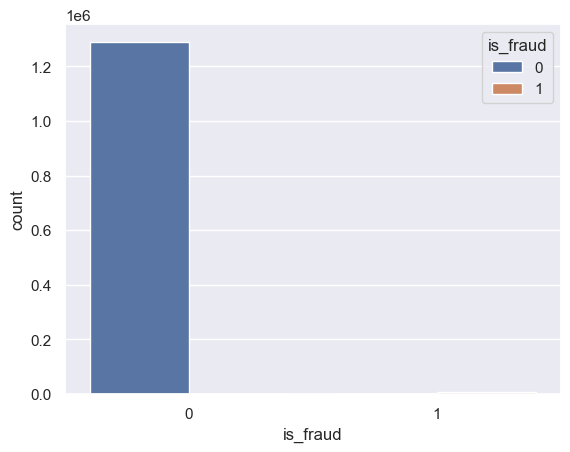

In [67]:
sns.countplot(data = df, x='is_fraud', hue = 'is_fraud')

In [68]:
# Calculate the percentage of the minority class which is the Fraud Cases
class_counts = df['is_fraud'].value_counts()
minority_percentage = (class_counts[1] / len(df)) * 100
majority_percentage = (class_counts[0] / len(df)) * 100
print("Percentage of minority class:", minority_percentage)
print("Percentage of majority class:", majority_percentage)

Percentage of minority class: 0.5788651743883394
Percentage of majority class: 99.42113482561166


Based on these distributions, we can see that the majority of the dataset contains non-fraud entries.
The fraud counts make up less than 1% of the dataset.
Therefore, there is a severe class imbalance. We will address this further down in the model

### Checking for Correlations

In [69]:
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64'])
numerical_cols.corr()['is_fraud'].sort_values()

month        -0.012409
unix_time    -0.005078
zip          -0.002162
cc_num       -0.000981
long          0.001721
merch_long    0.001721
merch_lat     0.001741
lat           0.001894
city_pop      0.002136
year          0.003004
age           0.012259
hour          0.013799
amt           0.219404
is_fraud      1.000000
Name: is_fraud, dtype: float64

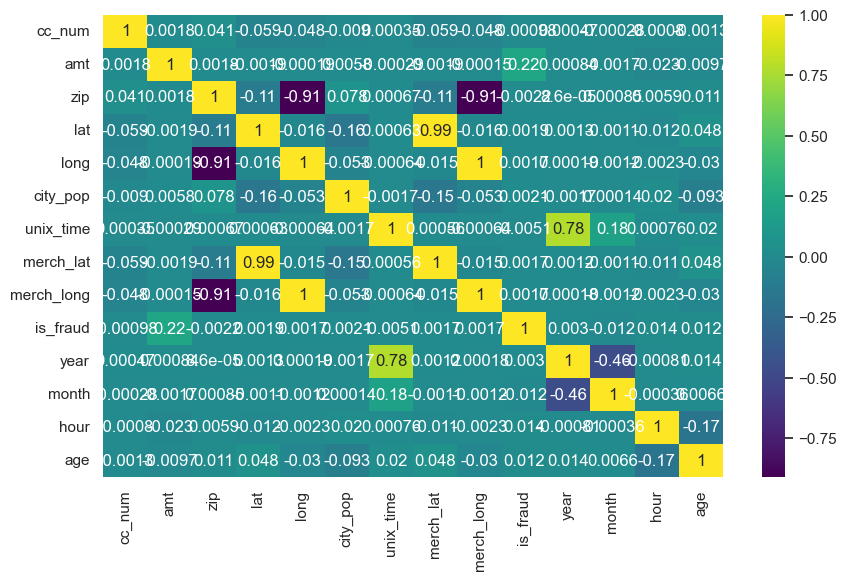

In [70]:
plt.figure(figsize=(10,6))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='viridis', cbar=True)
plt.show()

We see that the variable 'amt' is highly correlated with fraud. This shows that there is some relationship between those two variables.
Additionally, we see the merchant longitudal address is perfectly correlated with the customer's longitudal address. Also, the merchant latitude address is almost perfectly correlated with the customer's latitudal address. 
Lastly, the column zip is highly correlated with the merchant longitudal address.
These high correlations can result in issues such as multicollinearity in our model so we will drop the columns long, lat and zip. 

Also, since the variable 'amt' has the highest correlation value with 'is_fraud', we will deeply examine the different factors that are influencing this variable and its correlation to fraud. 

We will also calculate the Variance Inflation factor to check if there is any multicollinearities in our model before the Model building Process. 

In [71]:
# Dropping the columns that are highly correlated with other values in our model.
df = df.drop(columns =['long', 'lat', 'zip'])
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'street', 'city', 'state', 'city_pop', 'job', 'dob',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'trans_date',
       'year', 'month', 'day_of_week', 'hour', 'age'],
      dtype='object')

In [72]:
# We will keep the columns'trans_date_trans_time' and the variables we've derived from it. 
# Beacuse of this, we will drop unix_time because that the column is redundant.

df = df.drop(columns=['unix_time'])

This high correlation suggests that states with more transactions tend to have more fraudulent transactions. We are not seeing any deviances from that normal pattern here so we will explore the data more.

We are not seeing any unique patterns for fraudulent transcations associated with the regions. We see that higher counts of fraud is associated with higher counts of transactions overall. 

## Multi-Variate Analysis

<Axes: xlabel='is_fraud', ylabel='amt'>

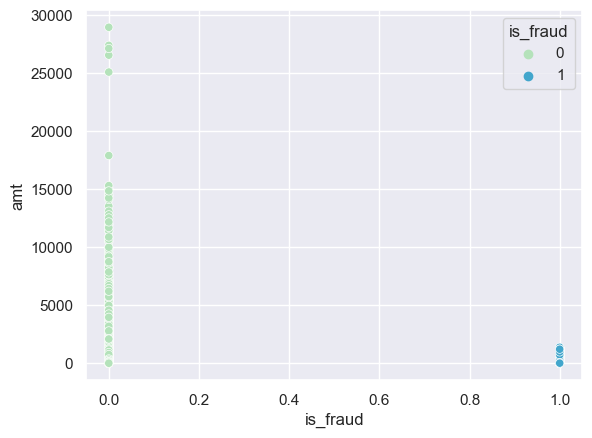

In [73]:
sns.scatterplot(x='is_fraud',y='amt',data=df,palette='GnBu',hue='is_fraud')

Based on the plot distribution above, we see that the amounts that is being spent on fraudulent transactions is within a lower range of numbers when compared to the non fraudulent cases. We would have expected that fraudulent transactions would have high dollar amounts but this is not the case here.

We will need to investigate why fraudulent transactions tend to be in a specific range of values. 

<Axes: xlabel='age', ylabel='amt'>

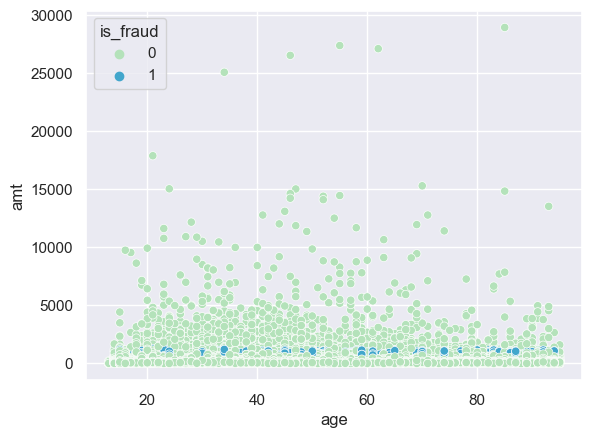

In [74]:
sns.scatterplot(x='age',y='amt',data=df,palette='GnBu',hue='is_fraud')

We can see that all the fraud transcations dollar figures are within in a specific vicinity and it is distributed across people of all ages.
We will still need to investigate more to see why the fraudulent transactions dollar amount are within a specific range of values. The inference we can gain from this is that fraudulent transactions tend to not be associated with a particular age group. There is another force that might contributing significantly to the correlation we observed with fraud.  

### Monthly Trends in Fraudulent Activity

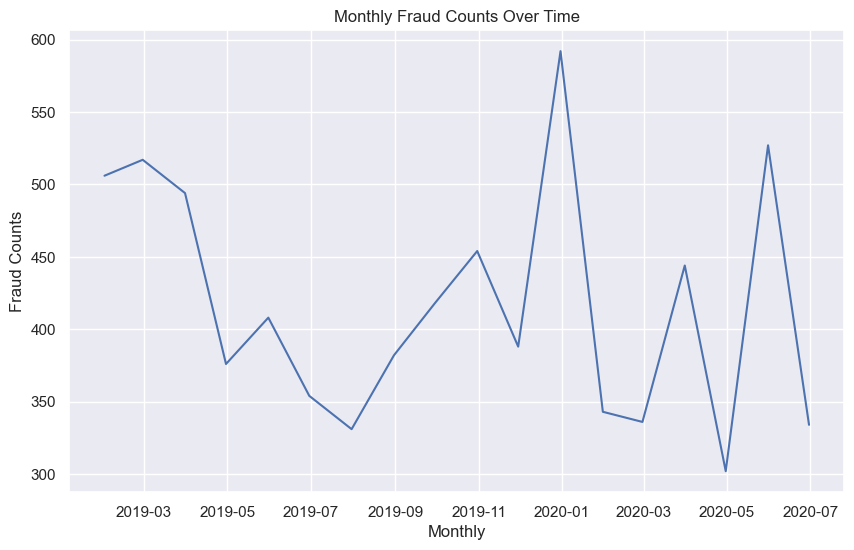

In [75]:
# Trend between Monthly Fraudulent Activity 

# Filtering out fraudulent transactions
fraud_df = df[df['is_fraud'] == 1]

# Resampling the data to get the total 'fraud_counts' for each Month
monthly_fraud_counts = fraud_df.resample('M', on='trans_date').size()

# Plotting the data
plt.figure(figsize=(10,6))
plt.plot(monthly_fraud_counts.index, monthly_fraud_counts.values)
plt.title('Monthly Fraud Counts Over Time')
plt.xlabel('Monthly')
plt.ylabel('Fraud Counts')
plt.show()

del fraud_df

This line chart shows us the monthly fraud counts (counts of Fraudulent Activity) in the dataset. We see that in the Christmas Period through to the New year in 2020, there has been a sharp increase in the number of fraudulent activity. This shows that Fraudulent activity peaks during the Christmas time.

### Weekly Trends in Fraudulent Activity.

In [76]:
# Converting the days of the week into labels that follow a temporal pattern through the days of the week.

day_of_week_hierarchy = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday':2,
    'Wednesday':3,
    'Thursday': 4, 
    'Friday' : 5,
    'Saturday': 6
    
}
df['day_of_week'] = df['day_of_week'].map(day_of_week_hierarchy)

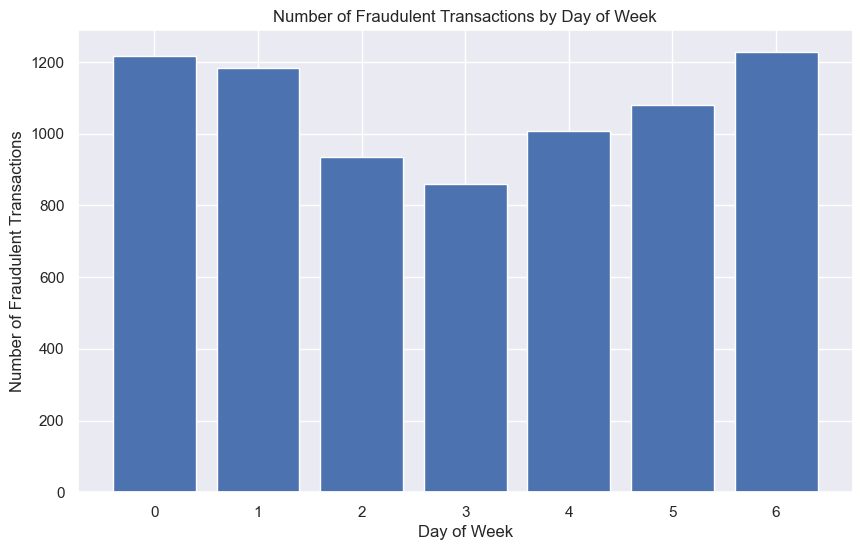

<----Fraud Counts on a Weekly basis---->
day_of_week
6    1227
0    1216
1    1182
5    1079
4    1008
2     935
3     859
dtype: int64


In [77]:
# Filter out fraudulent transactions
fraud_df = df[df['is_fraud'] == 1]

# Group by 'day_of_week' and count the number of fraudulent transactions for each day
fraud_counts = fraud_df.groupby('day_of_week').size()

# Sort the counts in descending order
fraud_counts_sorted = fraud_counts.sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10,6))
plt.bar(fraud_counts_sorted.index, fraud_counts_sorted.values, color='b')

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Number of Fraudulent Transactions by Day of Week')

# Display the plot
plt.show()


# Printing the result
print('<----Fraud Counts on a Weekly basis---->')
print(fraud_counts_sorted)

del fraud_df

Based on the findings, we see that fraudulent transactions are higher on Saturdays, Sundays and Mondays. This is over the weekdays. We will want to figure out why transactions are higher on weekends than weekdays.

So far, we can infer that fraudulent transactions tend to happen more over the weekends when compared to weekdays. We also see that fraudulent transactions tends to happen more in categories like shopping_net, grocery_pos and misc_net. 

It seems likely that most of the customers are making weekend purchases mostly online and at the grocery store and they are being defrauded. The inference is that they are not at work or engaging in their professions! This could explain why the credit cards are having fraudulent transactions cases in categories like entertainment, food dining and home even though they are in sparser numbers when compared to categories like shopping_net, grocery_pos and misc_net.

### Daily Trends in Fraudulent Activity.

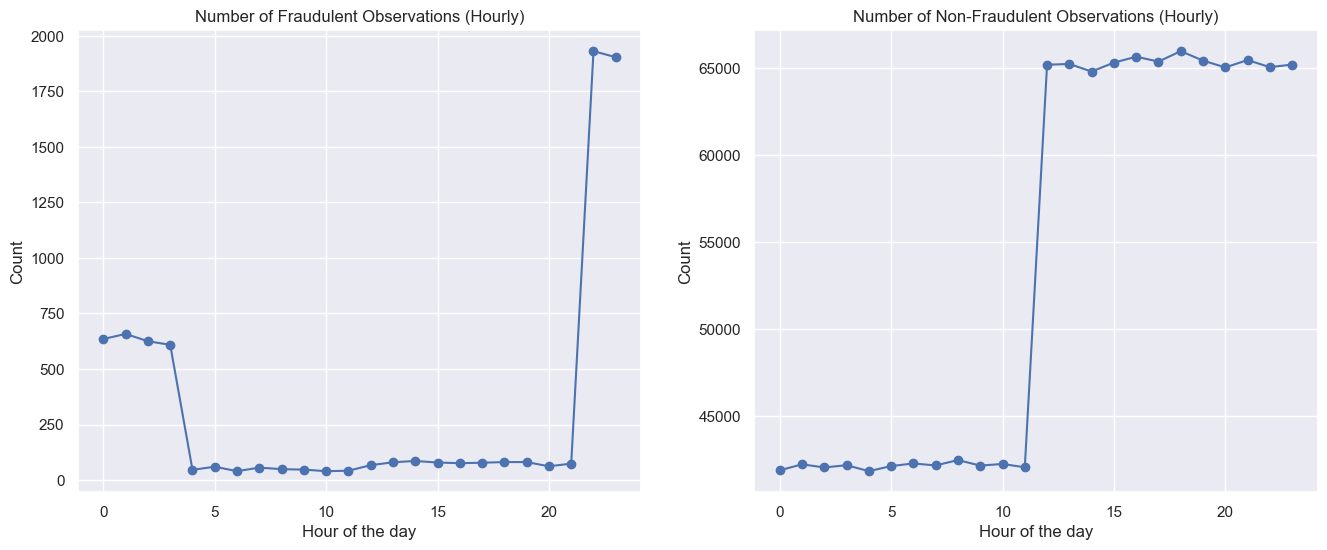

In [78]:
# Assuming 'df' is your DataFrame and 'region' is the column with regions

# Filter out fraudulent and non-fraudulent transactions
fraud_df = df[df['is_fraud'] == 1]
non_fraud_df = df[df['is_fraud'] == 0]

# Group by 'hour' and count the number of transactions in each hour
fraud_hour_counts = fraud_df.groupby('hour').size()
non_fraud_hour_counts = non_fraud_df.groupby('hour').size()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot fraudulent transactions
axs[0].plot(fraud_hour_counts.index, fraud_hour_counts.values, marker= 'o', linestyle='-')
axs[0].set_xlabel('Hour of the day')
axs[0].set_ylabel('Count')
axs[0].set_title('Number of Fraudulent Observations (Hourly)')

# Plot non-fraudulent transactions
axs[1].plot(non_fraud_hour_counts.index, non_fraud_hour_counts.values, marker = 'o', linestyle='-')
axs[1].set_xlabel('Hour of the day')
axs[1].set_ylabel('Count')
axs[1].set_title('Number of Non-Fraudulent Observations (Hourly)')

plt.show()

del fraud_df, non_fraud_df

Based on this display, we can see that the hours of 10 PM and 11 PM in the night is associated with an increase in fraudulent transactions. We will want to know the reasons behind this. Also, we will bin these categories by making the hours of 10 PM and 11 PM be priority for High risk of fraudulent transactions. Likewise, the hours of 12 AM to 3 AM would be classified for Medium Risk hours of fraudulent transactions and the rest of the hours be for Low Risk Hours for fraudulent transactions.

As for the non-fraudulent transactions, we can see that after the hours of 11 AM in the day, there is a noticable spike in Non-Fraudulent transactions. When we compare this to the fraudulent transactions frequency plot, we can see a noticable difference. We can isolate the hours where there is peak fraudulent activity in transactions which is during the hours of 11 PM to 3 PM since the spike in fraud counts during those early morning hours is not associated with a general increased transactional activity during those hours. 

### Fraudulent Activity Across Categories 

In [79]:
df['category'].value_counts()

category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'misc_net'),
  Text(1, 0, 'grocery_pos'),
  Text(2, 0, 'entertainment'),
  Text(3, 0, 'gas_transport'),
  Text(4, 0, 'misc_pos'),
  Text(5, 0, 'grocery_net'),
  Text(6, 0, 'shopping_net'),
  Text(7, 0, 'shopping_pos'),
  Text(8, 0, 'food_dining'),
  Text(9, 0, 'personal_care'),
  Text(10, 0, 'health_fitness'),
  Text(11, 0, 'travel'),
  Text(12, 0, 'kids_pets'),
  Text(13, 0, 'home')])

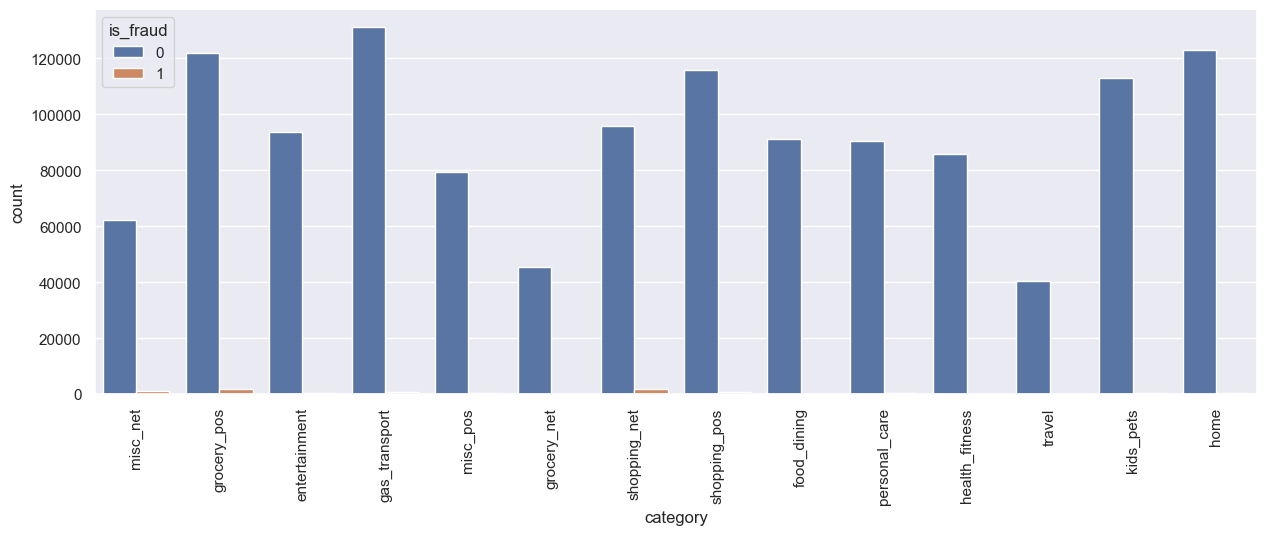

In [80]:
plt.figure(figsize=(15, 5))
sns.countplot(x='category', hue='is_fraud', data=df)
plt.xticks(rotation = 90)

Based on the above distribution, we can see that the the counts of fraudulent transactions is highest in the shopping_net categories, as well as the grocery_pos categories ,and the misc_net categories. However, they are in small numbers when compared to the non-fraudulent transactions.
Be that as it may, these categories are considered as Hot-Spots for fraudulent transactions. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'misc_net'),
  Text(1, 0, 'grocery_pos'),
  Text(2, 0, 'entertainment'),
  Text(3, 0, 'gas_transport'),
  Text(4, 0, 'misc_pos'),
  Text(5, 0, 'grocery_net'),
  Text(6, 0, 'shopping_net'),
  Text(7, 0, 'shopping_pos'),
  Text(8, 0, 'food_dining'),
  Text(9, 0, 'personal_care'),
  Text(10, 0, 'health_fitness'),
  Text(11, 0, 'travel'),
  Text(12, 0, 'kids_pets'),
  Text(13, 0, 'home')])

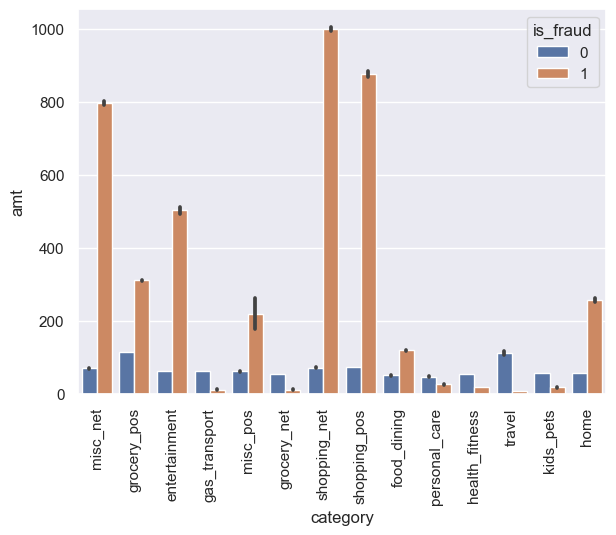

In [81]:
fig= plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.barplot(x='category', y='amt', hue='is_fraud', data=df)
plt.xticks(rotation = 90)

Based on the above distribution, we can see that the range of dollar figures being spent on fraud is highest in the shopping_net category. 
We can see other similarities in the shopping_pos, misc_net, misc_pos and home categories. 
The dollar figures for these fraud cases are ranging above $0 - $1000 dollars. 

So therefore, when we compare the counts of fraud transactions in each category with the dollar amounts being spent within each categories, we see that categories like 'shopping_net' and 'grocery_pos' are indeed hotspots for fraud transactions with dollar values spanning from above 0 dollars to 1000 dollars. 
It is also important to note that even though the categories of 'misc_net', 'misc_pos' and 'home' contains fraudulent transactions with high amounts being spent, they are not hot targets categories for fraud as they don't have high counts of fraud transactions. 

# Feature Engineering 

In [82]:
# Uncovering new relationships between the categories in the dataset and its correlation to the variable'amt'.

category_encoded = pd.get_dummies(df['category'], prefix='category')

category_encoded = category_encoded.astype(int)

df = pd.concat([df, category_encoded], axis=1)

In [83]:
# Changing the values in the Gender column to boolean for the Machine Learning process. 
gender_hierarchy = {
    'F': 0,
    'M': 1
}
df['gender'] = df['gender'].map(gender_hierarchy)

By observing these new correlated cases, we can see that there is some relationship with shopping_net transactions, grocery_pos transactions and misc_net transactions and how it tend to be more fraudulent. We will continue to explore the different variables in the dataset to uncover new correlations.

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

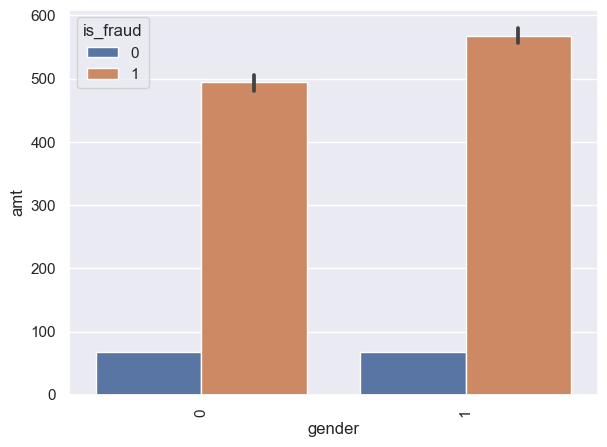

In [84]:
fig= plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.barplot(x = 'gender', y='amt', hue='is_fraud', data=df)
plt.xticks(rotation = 90)

Based on this distribution, we can see that the amounts that is being spent on fraud is a bit higher in the male category than in the female category. We are not really seeing any much relationships coming out from this graph to explain the reasons under which we saw the variable 'amt' being correlated to fraudulent transactions 'is_fraud'. 

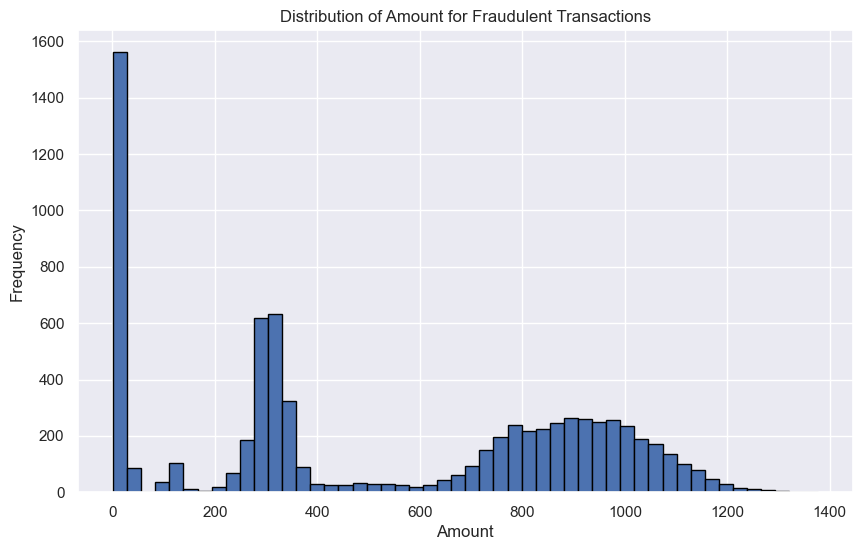

In [85]:
# Plotting the distribution of the fraudulent transactions in the dataset
fraud_df = df[df['is_fraud'] == 1]

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(fraud_df['amt'], bins=50, edgecolor='black')

plt.title('Distribution of Amount for Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [86]:
# Getting statistics

print("<------Fraud Statistics------->")
print(fraud_df['amt'].describe())

<------Fraud Statistics------->
count    7506.000000
mean      531.320092
std       390.560070
min         1.060000
25%       245.662500
50%       396.505000
75%       900.875000
max      1376.040000
Name: amt, dtype: float64


Based on the distribution of the dollar figures spent on fraud, we can see that fraudulent transactions are spread out from a minimum of 1 dollars to 1376.04 dollars. Therefore, fraudulent transactions are not associated with higher transaction values. Due to the fact that the non fraudulent transaction have most of its transaction dollar figures within this range, we would need to come up with more variables that can help isolate fraudulent activity. 

In [87]:
# Create bins for different dollar amounts
bins = [0, 50, 100, 500, 1000, 5000, 10000, df['amt'].max()]
labels = ['0-50', '51-100', '101-500', '501-1000', '1001-5000', '5001-10000', '10001+']

# Assign each transaction to a bin
fraud_df['amt_bin'] = pd.cut(fraud_df['amt'], bins=bins, labels=labels)

# Count the number of fraudulent transactions in each bin
fraud_counts = fraud_df['amt_bin'].value_counts().sort_index()

print(fraud_counts)
del fraud_df

amt_bin
0-50          1607
51-100          45
101-500       2206
501-1000      2699
1001-5000      949
5001-10000       0
10001+           0
Name: count, dtype: int64


We realize that categories 501-1000 and 101-500 have the highest counts of fraud amts.  So amts in 101-1000 will be measured in category 1. 

We also realize that categories 0-50 and 1001-5000 contains the second highest counts of fraud. So amts in these categories should be in category 2. 

Otherwise the 3rd ranked counts of fraud will be in category 3

In [88]:
# Define the conditions for each category
conditions = [
    (df['amt'] >= 101) & (df['amt'] < 1000),
    (df['amt'] < 50) | ((df['amt'] >= 1001) & (df['amt'] < 5000)),
    (df['amt'] >= 50) & (df['amt'] < 101) | (df['amt'] >= 5000)
]

# Define the category values corresponding to each condition
values = [1, 2, 3]

# Use numpy's select function for vectorized conditional assignment
df['amt_category'] = np.select(conditions, values, default=3)

# Optionally, downcast the 'amt_category' to the smallest integer type
df['amt_category'] = pd.to_numeric(df['amt_category'], downcast='integer')

In [89]:
# Conducting One Hot Encoding to the variables in the amt_category Category
amt_encoded = pd.get_dummies(df['amt_category'], prefix='amount')

amt_encoded = amt_encoded.astype(int)

df = df.drop(columns=['amt_category'])

df = pd.concat([df, amt_encoded], axis=1)

In [90]:
# Define the conditions for each risk level
conditions = [
    df['day_of_week'].isin([4, 5, 6]),
    df['day_of_week'].isin([0, 1, 2]),
    df['day_of_week'] == 3
]

# Define the risk level values corresponding to each condition
risk_levels = ['High_risk_days', 'Mid_risk_days', 'Low_risk_days']

# Use numpy's select function for vectorized conditional assignment
df['risk_level'] = np.select(conditions, risk_levels, default='Low_risk_days')

# Optionally, convert 'risk_level' to 'category' data type to save memory
df['risk_level'] = df['risk_level'].astype('category')

In [91]:
risk_encoded = pd.get_dummies(df['risk_level'], prefix='risk_days')
risk_encoded = risk_encoded.astype(int)
df = pd.concat([df, risk_encoded], axis=1)
df = df.drop(columns=['day_of_week', 'risk_level'])

Based on our observations, we notice that the hours starting from after 9 PM to 11 PM in the night is associated with an increase in fraudulent transactions. We will bin these categories by making these hours 'High' risk hours for fraudulent transactions. Likewise, during the hours of 12 AM to 3 AM, they would be for 'Medium' Risk hours of fraudulent transactions and the rest of the hours be preserved for 'Low' Risk Hours.

In [92]:
# Vectorized assignment of risk levels
conditions = [
    df['hour'].isin([21, 22, 23]),
    df['hour'].isin([0, 1, 2, 3]),
    df['hour'].isin(range(4, 20))
]
choices = ['High Risk', 'Medium Risk', 'Low Risk']
df['Risk Level'] = np.select(conditions, choices)

# Create dummy variables for 'Risk Level' and concatenate them to the original DataFrame
df = pd.concat([df, pd.get_dummies(df['Risk Level'], prefix='risk_hours').astype(np.uint8)], axis=1)

In [93]:
# Drop the original 'Risk Level' columns
df = df.drop(columns=['Risk Level'])

In [94]:
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64'])
numerical_cols.corr()['is_fraud'].sort_values()

amount_3                   -0.049118
amount_2                   -0.027841
category_home              -0.017848
category_food_dining       -0.015025
category_kids_pets         -0.014967
category_health_fitness    -0.014885
month                      -0.012409
category_entertainment     -0.012200
category_personal_care     -0.012167
risk_days_Mid_risk_days    -0.010514
category_misc_pos          -0.008937
category_grocery_net       -0.007136
category_travel            -0.006924
category_gas_transport     -0.004851
cc_num                     -0.000981
merch_long                  0.001721
merch_lat                   0.001741
city_pop                    0.002136
year                        0.003004
risk_days_Low_risk_days     0.003381
category_shopping_pos       0.005955
gender                      0.007642
risk_days_High_risk_days    0.008701
age                         0.012259
hour                        0.013799
category_misc_net           0.025886
category_grocery_pos        0.035558
c

### Categories of transactions that are fraudulent in the High Risk Hours.

In [95]:
# Filter the DataFrame for transactions that occurred during 'High Risk' hours
high_risk_hours_df = df[(df['hour'] >= 21) | (df['hour'] <= 3)]

# Filter for fraudulent transactions
fraud_high_risk_hours_df = high_risk_hours_df[high_risk_hours_df['is_fraud'] == 1]

# Group by 'category' and count the number of fraudulent transactions for each category
category_fraud_counts = fraud_high_risk_hours_df.groupby('category').size()

# Convert the groupby object to a DataFrame and reset the index
category_fraud_counts = category_fraud_counts.to_frame(name='counts').reset_index()

# Sort the DataFrame by 'counts' in descending order to see the categories with the most fraudulent transactions
category_fraud_counts = category_fraud_counts.sort_values('counts', ascending=False)

# Display the DataFrame
print(category_fraud_counts)


# Sum the counts of fraudulent transactions
total_fraud_counts = category_fraud_counts['counts'].sum()

# Print the total number of fraudulent transactions
print(f'Total number of fraudulent transactions during both High and Medium Risk hours: {total_fraud_counts}')


          category  counts
4      grocery_pos    1504
11    shopping_net    1476
8         misc_net     792
12    shopping_pos     704
2    gas_transport     541
9         misc_pos     205
7        kids_pets     202
0    entertainment     199
10   personal_care     189
6             home     179
1      food_dining     127
3      grocery_net     114
5   health_fitness     107
13          travel      97
Total number of fraudulent transactions during both High and Medium Risk hours: 6436


We see that during the High Risk Hours and the Medium Risk Hours, there are more grocery_pos transcations, shopping_net transcations and misc_net fraudulent transactions relative to the other remaining categories in the other hours of the day. Additionally, we also see that 6436 fraud transcations out of the total 7506 fraud transcations in the dataset are occuring during these High Risk Fraud Hours. This is to say that approximately 86% of all the Fraud transcations are occuring during hours of 9 PM to 3 AM. 

### Amounts spent on Transactions in 24 Hours

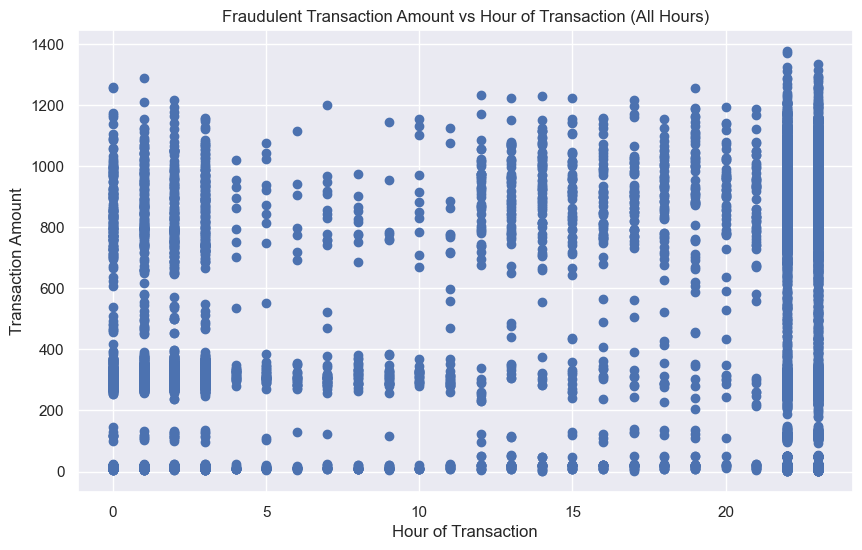

In [96]:
# Filter out transactions that are not fraudulent
df_fraud = df[df['is_fraud'] == 1]

# Create the scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_fraud['hour'], df_fraud['amt'])
plt.xlabel('Hour of Transaction')
plt.ylabel('Transaction Amount')
plt.title('Fraudulent Transaction Amount vs Hour of Transaction (All Hours)')
plt.show()

We notice that there is an increased number of transactions during the hours of 10 PM and 11 PM. We can notice this by looking at the distribution of the scatter plots and seeing how close the points are to each other - almost forming a continuous line. The distribution of the lines tend to become just a bit more dispered during the hours of Midnight to 4 PM which after those hours, the points are even more dispered. Also, we know that the spread of the fraudulent changes during the High Risk hours are a bit wider which suggests that consumers are spending more on fraudulent transactions during these hours. 

Based on the results of this graph, we will try to create a variable that can measure the average amount spend during the hours of the day as well as creating a metric to measure the frequency of transactions across all risk hours. Increased frequency of transactions across all credit cards during these hours could prove to be a valuable metric for detecting fraud.

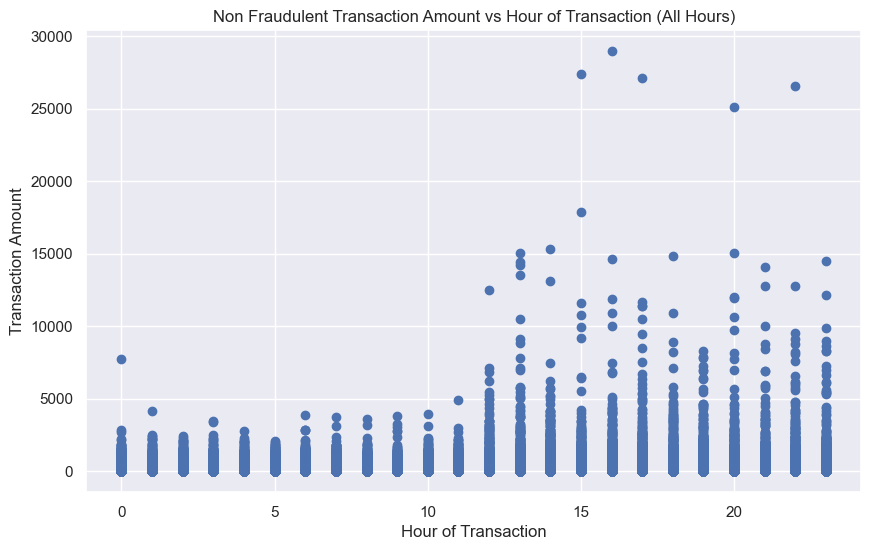

In [97]:
# Filter out transactions that are not fraudulent
df_fraud = df[df['is_fraud'] == 0]

# Create the scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_fraud['hour'], df_fraud['amt'])
plt.xlabel('Hour of Transaction')
plt.ylabel('Transaction Amount')
plt.title('Non Fraudulent Transaction Amount vs Hour of Transaction (All Hours)')
plt.show()


In [98]:
# Filter the DataFrame for transactions that occurred during 'Low Risk' hours
low_risk_hours_df = df[df['hour'].isin(range(4, 20))]

# Filter for fraudulent transactions
fraud_low_risk_hours_df = low_risk_hours_df[low_risk_hours_df['is_fraud'] == 1]

# Group by 'category' and count the number of fraudulent transactions for each category
category_fraud_counts_low_risk = fraud_low_risk_hours_df.groupby('category').size()

# Convert the groupby object to a DataFrame and reset the index
category_fraud_counts_low_risk = category_fraud_counts_low_risk.to_frame(name='counts').reset_index()

# Sort the DataFrame by 'counts' in descending order to see the categories with the most fraudulent transactions
category_fraud_counts_low_risk = category_fraud_counts_low_risk.sort_values('counts', ascending=False)

# Display the DataFrame
print(category_fraud_counts_low_risk)

# Sum the counts of fraudulent transactions
total_fraud_counts_low_risk = category_fraud_counts_low_risk['counts'].sum()

# Print the total number of fraudulent transactions
print(f'Total number of fraudulent transactions during Low Risk hours: {total_fraud_counts_low_risk}')

          category  counts
4      grocery_pos     235
11    shopping_net     215
12    shopping_pos     130
8         misc_net     111
2    gas_transport      77
9         misc_pos      44
7        kids_pets      36
0    entertainment      30
10   personal_care      28
5   health_fitness      25
1      food_dining      23
3      grocery_net      20
13          travel      18
6             home      16
Total number of fraudulent transactions during Low Risk hours: 1008


We see that during the Low Risk Hours, the top categories for fraudulent activity remains roughly the same in that its consistent with the top categories during High Risk Hours. We notice that in these second tier hours, there are 1008 fraud transcations out of the total 7506 fraud transcations in the dataset. This is to say that approximately 13.3% of all the Fraud transcations are occuring during hours. This is a significant drop when compared to fraudulent activity duing the High Risk Hours. 

Due to the fact that a significant 85% of fraudulent data take place during the hours of 9 PM to 3 AM and its concentrated heavily in the categories of shopping_net, grocery_pos, misc_net and shopping_pos, we will categorize these columns as High Risk Categories. We will also rank the other categories and their associated values into Medium and Low Risk Categories. 

In [99]:
# Vectorized assignment of risk levels
conditions = [
    df['category'].isin(['shopping_net', 'grocery_pos', 'misc_net']),
    df['category'].isin(['shopping_pos', 'gas_transport', 'misc_pos', 'kids_pets', 'entertainment', 'personal_care', 'home'])
]
choices = ['High Risk Category', 'Medium Risk Category']
df['Risk Level'] = np.select(conditions, choices, default='Low Risk Category')

# Convert 'category' column to 'category' data type to save memory
df['category'] = df['category'].astype('category')

# Create dummy variables for 'Risk Level' and concatenate them to the original DataFrame
risk_level_encoded = pd.get_dummies(df['Risk Level'], prefix='risk_level').astype(np.uint8)
df = pd.concat([df, risk_level_encoded], axis=1)

# Drop the original 'Risk Level' column
df = df.drop('Risk Level', axis=1)

# Get a list of all the encoded category columns
encoded_cols = [col for col in df.columns if 'category_' in col]

# Drop the original 'category' column and the encoded category columns
df = df.drop(['category'] + encoded_cols, axis=1)

### Data Processing Pipeline

In [100]:
# Convert 'trans_date_trans_time' to datetime and set as index, sort the DataFrame
df_series = df.copy().assign(time_index=pd.to_datetime(df['trans_date_trans_time'])).set_index('time_index').sort_index()

# Print DataFrame after preprocessing
print("After preprocessing:")
print(df_series)

After preprocessing:
                    trans_date_trans_time               cc_num  \
time_index                                                       
2019-01-01 00:00:18   2019-01-01 00:00:18     2703186189652095   
2019-01-01 00:00:44   2019-01-01 00:00:44         630423337322   
2019-01-01 00:00:51   2019-01-01 00:00:51       38859492057661   
2019-01-01 00:01:16   2019-01-01 00:01:16     3534093764340240   
2019-01-01 00:03:06   2019-01-01 00:03:06      375534208663984   
...                                   ...                  ...   
2020-06-21 12:12:08   2020-06-21 12:12:08       30263540414123   
2020-06-21 12:12:19   2020-06-21 12:12:19     6011149206456997   
2020-06-21 12:12:32   2020-06-21 12:12:32     3514865930894695   
2020-06-21 12:13:36   2020-06-21 12:13:36     2720012583106919   
2020-06-21 12:13:37   2020-06-21 12:13:37  4292902571056973207   

                                                merchant     amt  gender  \
time_index                                  

### 24 hr Average Amount spent for each Credit Card. 

In [101]:
# Group by 'cc_num', resample to hourly intervals, calculate the mean, and shift the averages
df_avg_amt_24hr = (df_series.groupby('cc_num')['amt']
                   .rolling('24H')
                   .mean()
                   .shift(1)
                   .reset_index()
                   .fillna(0))

# Rename the columns
df_avg_amt_24hr.columns = ['cc_num', 'trans_date_trans_time', 'avg_amt_24hr']

# Print DataFrame after calculating 24-hour Average Amount
print("After calculating 24-hour Average Amount:")
df_avg_amt_24hr

After calculating 24-hour Average Amount:


,cc_num,trans_date_trans_time,avg_amt_24hr
0,60416207185,2019-01-01 12:47:15,0.000000
1,60416207185,2019-01-02 08:44:57,7.270000
2,60416207185,2019-01-02 08:47:36,30.105000
3,60416207185,2019-01-02 12:38:14,47.430000
4,60416207185,2019-01-02 13:10:46,44.270000
...,...,...,...
1296670,4992346398065154184,2020-06-20 21:04:59,5.743333
1296671,4992346398065154184,2020-06-21 00:41:01,19.425000
1296672,4992346398065154184,2020-06-21 02:47:59,37.342500
1296673,4992346398065154184,2020-06-21 08:04:28,79.186000


In [102]:
# Sorting by the minimum 24-hour average amount
df_avg_amt_24hr = df_avg_amt_24hr.groupby(['cc_num','trans_date_trans_time'])\
['avg_amt_24hr'].min().reset_index()

df = pd.merge(df, df_avg_amt_24hr, on=['cc_num', 'trans_date_trans_time'], how='left')

### Creating Interaction Features

In [104]:
# Aggregrating the risks columns 
df['agg_High_risk_cols'] = df['risk_hours_High Risk']* df['amount_1'] * df['risk_level_High Risk Category'] * df['avg_amt_24hr']
df['agg_medium_risk_cols'] = df['risk_hours_Medium Risk'] * df['amount_2'] * df['risk_level_Medium Risk Category'] * df['avg_amt_24hr']
df['agg_low_risk_cols'] = df['risk_hours_Low Risk'] * df['amount_3'] * df['risk_level_Low Risk Category'] * df['avg_amt_24hr']

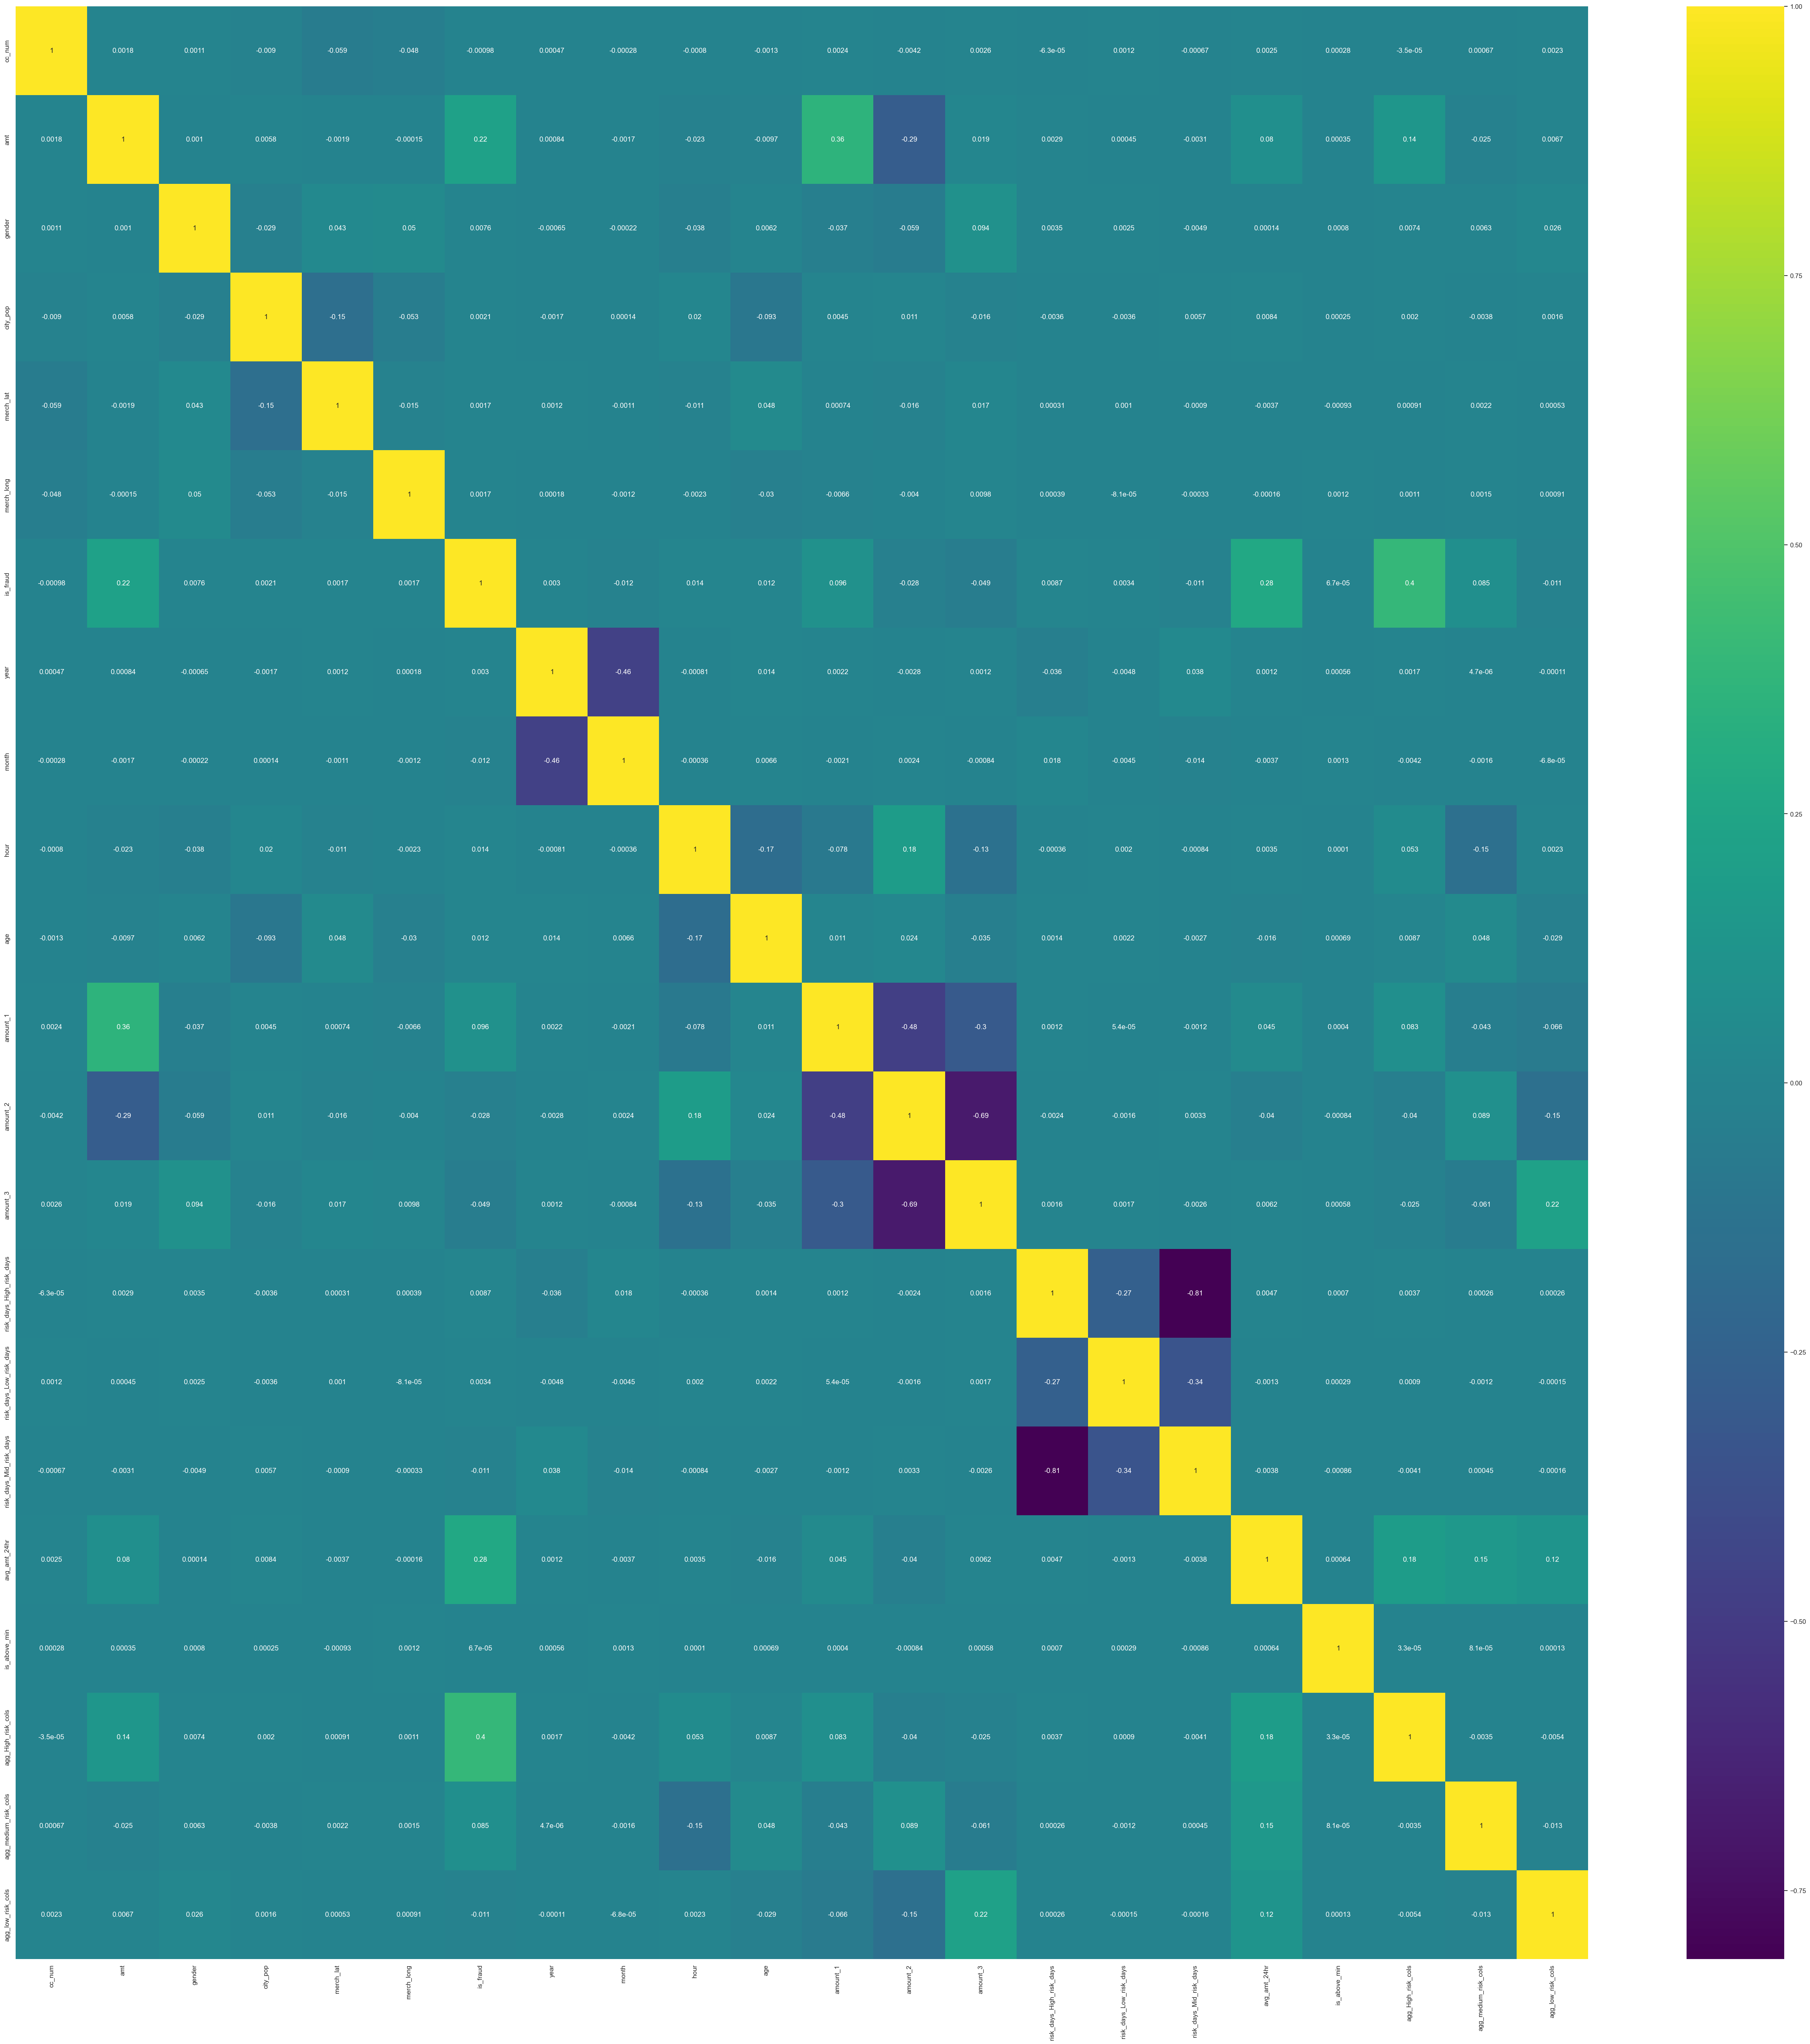

In [105]:
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64'])
plt.figure(figsize=(60,60))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='viridis', cbar=True)
plt.show()

In [106]:
numerical_cols.corr()['is_fraud'].sort_values()

amount_3                   -0.049118
amount_2                   -0.027841
month                      -0.012409
agg_low_risk_cols          -0.010589
risk_days_Mid_risk_days    -0.010514
cc_num                     -0.000981
is_above_min                0.000067
merch_long                  0.001721
merch_lat                   0.001741
city_pop                    0.002136
year                        0.003004
risk_days_Low_risk_days     0.003381
gender                      0.007642
risk_days_High_risk_days    0.008701
age                         0.012259
hour                        0.013799
agg_medium_risk_cols        0.084977
amount_1                    0.096071
amt                         0.219404
avg_amt_24hr                0.275810
agg_High_risk_cols          0.397121
is_fraud                    1.000000
Name: is_fraud, dtype: float64

# Feature Selection

### Variance Inflation Factor | Detecting Multicollinearities

In [107]:
# Import necessary libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df is your DataFrame and numerical_cols is a list of your numerical columns
numerical_cols = ['month', 'cc_num', 'merch_long', 'merch_lat', 'city_pop', 'year', 'age', 'hour', 'amt', 'risk_hours_Low Risk', 'amount_3', 'amount_2', 'risk_hours_High Risk', 
                  'risk_hours_Medium Risk', 'amount_1', 'risk_level_Medium Risk Category', 'risk_level_High Risk Category', 'risk_level_Low Risk Category', 'risk_days_High_risk_days', 'risk_days_Low_risk_days', 'risk_days_Mid_risk_days', 'gender', 'hour',
                 'agg_High_risk_cols', 'agg_medium_risk_cols', 'agg_low_risk_cols', 'avg_amt_24hr']   

df_numeric = df[numerical_cols]

# Add a constant term to the DataFrame. This is needed because the VIF method in statsmodels does not add it by default
df_numeric['Intercept'] = 1

# Calculate VIF
vif = pd.DataFrame()
vif["variables"] = df_numeric.columns
vif["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

print(vif)

                          variables       VIF
0                             month  0.269207
1                            cc_num  1.006455
2                        merch_long  1.004353
3                         merch_lat  1.024648
4                          city_pop  0.925919
5                              year  0.747239
6                               age  0.145675
7                              hour  0.253425
8                               amt  0.861982
9               risk_hours_Low Risk  0.375597
10                         amount_3  0.729515
11                         amount_2  0.523096
12             risk_hours_High Risk  0.868597
13           risk_hours_Medium Risk  0.885367
14                         amount_1  0.849967
15  risk_level_Medium Risk Category  0.464210
16    risk_level_High Risk Category  0.809389
17     risk_level_Low Risk Category  0.825079
18         risk_days_High_risk_days  0.653680
19          risk_days_Low_risk_days  0.913340
20          risk_days_Mid_risk_day

Based on the correlations as well as the VIF Metrics, we can see that our model doesn't have any much multicollinearities as all the predictor variables are mostly independent and doesn't correlate with any other predictor variables. We will remove the risk_days_Mid_risk_days and the risk_days_High_risk_days since they show high correlations with each other as well as their correlation values to the target variable is weak. 

In [108]:
# Dropping unnecessary columns that doesn't hold any substantial information to our model
df = df.drop(columns=['trans_date_trans_time', 'trans_date', 'dob', 'city', 'risk_days_High_risk_days', 'risk_days_Mid_risk_days'])

# Conducting Label encoding for it understands word labels

from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 
  
# Encoding labels of following columns.  
df['job']= label_encoder.fit_transform(df['job']) 
df['merchant']= label_encoder.fit_transform(df['merchant'])
df['street']= label_encoder.fit_transform(df['street'])
df['state']= label_encoder.fit_transform(df['state'])

In [109]:
# Save DataFrame to a CSV file
# df.to_csv('new_engineered_features.csv', index=False)